In [138]:
#This is is for the predicted contours, not for the ground truths

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import csv
from skimage.measure import label, regionprops
import matplotlib.patches as patches
from sklearn.metrics import jaccard_score
from tqdm import tqdm 
import seaborn as sns
import pandas as pd

In [3]:
root_main_gtv = '/media/umcg/e80a10e0-88c6-4b42-8891-52f96603fe7a/home/umcg/Desktop/AutomaticITV_code/DataCh1/SABR1322_Nifti/'
root_main_itv = '/media/umcg/e80a10e0-88c6-4b42-8891-52f96603fe7a/home/umcg/Desktop/AutomaticITV_code/DataCh1/figures_SwinDyn_V12_ITV_Archived/'
#root_main = '//zkh/appdata/RTDicom/DAMEproject/LungSABR_data/Dicom data renamed Nifti/MultipleBreathingP'
root_save = 'C:/Users/delaOArevaLR/OneDrive - UMCG/Code/Chapter1/ImagesFromScripts/ITV-GTV-SizeDifferences/'

In [4]:
pxGTV= os.listdir(root_main_gtv)
pxITV= os.listdir(root_main_itv)
pxOverlap=[]
for currGTV in pxGTV:
    if currGTV in pxITV:
        pxOverlap.append(currGTV)
        
print("Px GTV",len(pxGTV),"ITV",len(pxITV),"Overlap",len(pxOverlap))

Px GTV 63 ITV 61 Overlap 53


In [70]:
def display_Fun(struct,image,views_itv,views_gtv,bbox_itv,bbox_gtv,path2save):
    if not(os.path.exists(path2save)):
        os.mkdir(path2save)
    midSlice_x, midSlice_y, midSlice_z = MidTumorSliceFinder(itv)

    minrow,maxrow,mincol,maxcol = bbox_itv[0],bbox_itv[1],bbox_itv[4],bbox_itv[5]
    minrow_g,maxrow_g,mincol_g,maxcol_g = bbox_gtv[0],bbox_gtv[1],bbox_gtv[4],bbox_gtv[5]
    plt.imshow((ct[midSlice_x,:,:]),cmap='gray'),plt.axis('off')
    #plt.contour(np.rot90(views_itv[0]-views_gtv[0])),plt.axis('off')#,plt.show()
    plt.contour((views_itv[0]),colors='r'),plt.axis('on')#,plt.show()
    #plt.contour((views_gtv[0]),colors='b')
    plt.gca().add_patch(patches.Rectangle((mincol,minrow),maxcol-mincol,maxrow-minrow,linewidth=1,edgecolor='r',facecolor='white'))
    #plt.gca().add_patch(patches.Rectangle((mincol_g,minrow_g),maxcol_g-mincol_g,maxrow_g-minrow_g,linewidth=1,edgecolor='b',facecolor='blue'))
    plt.savefig(path2save+"/X.png"),plt.clf()

    minrow,maxrow,mincol,maxcol = bbox_itv[2],bbox_itv[3],bbox_itv[4],bbox_itv[5]
    minrow_g,maxrow_g,mincol_g,maxcol_g = bbox_gtv[2],bbox_gtv[3],bbox_gtv[4],bbox_gtv[5]
    plt.imshow((ct[:,midSlice_y,:]),cmap='gray'),plt.axis('off')
    #plt.contour(np.rot90(views_itv[1]-views_gtv[1])),plt.axis('off')
    plt.contour((views_itv[1]),colors='r'),plt.axis('on')#,plt.show()
    #plt.contour((views_gtv[1]),colors='b')
    #plt.gca().add_patch(patches.Rectangle((mincol,minrow),maxcol-mincol,maxrow-minrow,linewidth=1,edgecolor='r',facecolor='white'))
    plt.gca().add_patch(patches.Rectangle((mincol_g,minrow_g),maxcol_g-mincol_g,maxrow_g-minrow_g,linewidth=1,edgecolor='b',facecolor='blue'))
    plt.savefig(path2save+"/Y.png"),plt.clf()

    minrow,maxrow,mincol,maxcol = bbox_itv[2],bbox_itv[3],bbox_itv[0],bbox_itv[1]
    minrow_g,maxrow_g,mincol_g,maxcol_g = bbox_gtv[2],bbox_gtv[3],bbox_gtv[0],bbox_gtv[1]
    plt.imshow((ct[:,:,midSlice_z]),cmap='gray'),plt.axis('off')
    #plt.contour(np.rot90(views_itv[2]-views_gtv[2],-1)),plt.axis('off')
    plt.contour((views_itv[2]),colors='r'),plt.axis('on')#,plt.show()
    #plt.contour((views_gtv[2]),colors='b')
    plt.gca().add_patch(patches.Rectangle((mincol,minrow),maxcol-mincol,maxrow-minrow,linewidth=1,edgecolor='r',facecolor='white'))
    #plt.gca().add_patch(patches.Rectangle((mincol_g,minrow_g),maxcol_g-mincol_g,maxrow_g-minrow_g,linewidth=1,edgecolor='b',facecolor='blue'))
    plt.savefig(path2save+"/Z.png"),plt.clf()

In [71]:
def MidTumorSliceFinder(struct_np):
    x,y,z = np.where(struct_np!=0)
    midSlice_x = x.min() + (x.max()-x.min())//2
    midSlice_y = y.min() + (y.max()-y.min())//2
    midSlice_z = z.min() + (z.max()-z.min())//2

    return midSlice_x, midSlice_y, midSlice_z

In [101]:
def ScreenshotViews(ct_np,rt_np,saveJPEG_Path_Px=None,struct_name=None,Px=None,SecondImage=None):
    #ct_np = sitk.GetArrayFromImage(CT)
    #rt_np = sitk.GetArrayFromImage(BW_tumor)
    if SecondImage is not None:
        SecondImage = sitk.GetArrayFromImage(SecondImage)

    slice_sums = np.sum(rt_np, axis=(1, 2))
    axial_indices = np.where(slice_sums > 0)[0]
    axial_mid = len(axial_indices)//2

    coronal_sums = np.sum(rt_np, axis=(0, 2))
    coronal_indices = np.where(coronal_sums > 0)[0]
    coronal_mid = len(coronal_indices)//2

    sagittal_sums = np.sum(rt_np, axis=(0, 1))
    sagittal_indices = np.where(sagittal_sums > 0)[0]
    sagittal_mid = len(sagittal_indices)//2


    plt.subplot(131),plt.imshow(ct_np[axial_indices[axial_mid],:,:],cmap='gray')
    plt.subplot(131),plt.contour(rt_np[axial_indices[axial_mid],:,:],colors='red',linewidths=0.5),plt.axis('on')
    if SecondImage is not None:
        plt.subplot(131),plt.imshow(SecondImage[axial_indices[axial_mid],:,:],alpha=0.5,cmap='hot'),plt.axis('on')
    plt.subplot(132),plt.imshow(ct_np[:,coronal_indices[coronal_mid],:],cmap='gray')
    plt.subplot(132),plt.contour(rt_np[:,coronal_indices[coronal_mid],:],colors='red',linewidths=0.5),plt.axis('on')
    if SecondImage is not None:
        plt.subplot(132),plt.imshow(SecondImage[:,coronal_indices[coronal_mid],:],alpha=0.5,cmap='hot'),plt.axis('on')
    plt.subplot(133),plt.imshow(ct_np[:,:,sagittal_indices[sagittal_mid]],cmap='gray')
    plt.subplot(133),plt.contour(rt_np[:,:,sagittal_indices[sagittal_mid]],colors='red',linewidths=0.5),plt.axis('on')
    if SecondImage is not None:
        plt.subplot(133),plt.imshow(SecondImage[:,:,sagittal_indices[sagittal_mid]],alpha=0.5,cmap='hot'),plt.axis('on')
    plt.tight_layout()

    plt.show()
    return True

#_ = ScreenshotViews(CT_image,CTTumor_image,saveJPEG_Path_Px=None,struct_name="img1_",Px="001",SecondImage=None)

In [102]:
def jaccard_index(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def selectNP(itv_list,gtv_list):
    index = -1
    for currITV_np in itv_list: 
        for currGTV_np in gtv_list:
            currIndex = jaccard_index(currITV_np,currGTV_np)
            if currIndex>index:
                #print("score",currIndex)
                gtv_selected = currGTV_np
                itv_selected = currITV_np
                index = currIndex
    if index>0.1:
        print("Yes use")
        print("Best Index",index)
        boolUse = True
    else:
        print("NOT use")
        boolUse = False
        
    
    return gtv_selected,itv_selected,boolUse

In [103]:
def CropFun(currstruct,xmin,ymin,zmin):
    xcut= (currstruct.shape[0] - xmin) //2
    ycut= (currstruct.shape[1] - ymin) //2
    zcut= (currstruct.shape[2] - zmin) //2

    slices = [
    slice(xcut, -xcut if xcut != 0 else None),
    slice(ycut, -ycut if ycut != 0 else None),
    slice(zcut, -zcut if zcut != 0 else None)
    ]

    result = currstruct[tuple(slices)]
    return result

def FindMinAndCropFunction(gtv_list,itv_list,gtv_gt,itv_gt):
    xmin,ymin,zmin = 512,512,512
    for currstruct in gtv_list+itv_list+[gtv_gt]+[itv_gt]:
        if currstruct.shape[0]<xmin: xmin = currstruct.shape[0]
        if currstruct.shape[1]<ymin: ymin = currstruct.shape[1]
        if currstruct.shape[2]<zmin: zmin = currstruct.shape[2]
    print("mins",xmin,ymin,zmin)
    
    gtv_list_crop = []
    for currGTV in gtv_list:
        gtv_list_crop.append(CropFun(currGTV,xmin,ymin,zmin))
    
    itv_list_crop = []
    for currITV in itv_list:
        itv_list_crop.append(CropFun(currITV,xmin,ymin,zmin))
    
    gtv_gt_crop= CropFun(gtv_gt,xmin,ymin,zmin)
    itv_gt_crop= CropFun(itv_gt,xmin,ymin,zmin)
    print("From:",gtv_list[0].shape,itv_list[0].shape,gtv_gt.shape,itv_gt.shape)
    print("To: ",gtv_list_crop[0].shape,itv_list_crop[0].shape,gtv_gt_crop.shape,itv_gt_crop.shape)

    return gtv_list_crop,itv_list_crop,gtv_gt_crop,itv_gt_crop 

In [104]:
def LookForPaths(root_main_gtv,root_main_itv,currPx):
    itv_list,gtv_list = [],[]
    itv_np,gtv_np = None,None
    gtv_gt,itv_gt = None,None
    for root, dirs, files in os.walk(os.path.join(root_main_gtv,currPx)):
        for f in files:
            if "GTV_Predicted12" in f:#'gtv' in f.lower() and not("igtv" in f.lower()):
                gtvpath = os.path.join(root, f)
                gtv_temp = sitk.GetArrayFromImage(sitk.ReadImage(gtvpath))
                if np.sum(gtv_temp)>0:
                    gtv_np = sitk.GetArrayFromImage(sitk.ReadImage(gtvpath))
                    gtv_np[gtv_np>0]=1
                    gtv_list.append(gtv_np)
            elif "rtstruct" in f.lower() and not("predicted" in f.lower()):
                if "itv" in f.lower() or "igtv" in f.lower():
                    itv_gt_path = os.path.join(root, f)
                    itv_gt = sitk.GetArrayFromImage(sitk.ReadImage(itv_gt_path))
                    itv_gt = np.flip(itv_gt, (1,2))
                else:
                    gtv_gt_path = os.path.join(root, f)
                    gtv_gt = sitk.GetArrayFromImage(sitk.ReadImage(gtv_gt_path))
                    gtv_gt = np.flip(gtv_gt, (1,2))

    for root, dirs, files in os.walk(os.path.join(root_main_itv,currPx)):
        for f in files:
            if "predictedITV" in f:#'itv' in f.lower() or "igtv" in f.lower():
                itvpath = os.path.join(root, f)
                itv_temp = sitk.GetArrayFromImage(sitk.ReadImage(itvpath))
                if np.sum(itv_temp)>0:
                    itv_np = sitk.GetArrayFromImage(sitk.ReadImage(itvpath))
                    itv_np[itv_np>0]=1
                    itv_list.append(itv_np)
                    
    #print(gtv_np.shape,gtv_np.shape,gtv_gt.shape,itv_gt.shape)
    return gtv_list,itv_list,gtv_gt,itv_gt

In [116]:
def GetITVandGTVDifferences(itv,gtv):
    ventro_gtv,lateral_gtv,cranio_gtv,views_gtv,bbox_gtv,centroid = longest_axis_2d(gtv,None)
    ventro_itv,lateral_itv,cranio_itv,views_itv,bbox_itv,_ = longest_axis_2d(itv,centroid)
    
    cranio_diff_pos = abs(bbox_itv[1] - bbox_gtv[1])
    ventro_diff_pos = abs(bbox_itv[3] - bbox_gtv[3])
    lateral_diff_pos = abs(bbox_itv[5] - bbox_gtv[5])

    cranio_diff_neg = abs(bbox_itv[0] - bbox_gtv[0])
    ventro_diff_neg = abs(bbox_itv[2] - bbox_gtv[2])
    lateral_diff_neg = abs(bbox_itv[4] - bbox_gtv[4])

    #hist_cranio_neg.append(cranio_diff_neg)
    #hist_ventro_neg.append(ventro_diff_neg)
    #hist_lateral_neg.append(lateral_diff_neg)

    if bbox_itv[0]<bbox_gtv[0]: bbox_itv0 = bbox_gtv[0]
    else:bbox_itv0 = bbox_itv[0]
    if bbox_itv[1]<bbox_gtv[1]: bbox_itv1 = bbox_gtv[1]
    else:bbox_itv1 = bbox_itv[1]
    if bbox_itv[2]<bbox_gtv[2]: bbox_itv2 = bbox_gtv[2]
    else:bbox_itv2 = bbox_itv[2]
    if bbox_itv[3]<bbox_gtv[3]: bbox_itv3 = bbox_gtv[3]
    else:bbox_itv3 = bbox_itv[3]
    if bbox_itv[4]<bbox_gtv[4]: bbox_itv4 = bbox_gtv[4]
    else:bbox_itv4 = bbox_itv[4]
    if bbox_itv[5]<bbox_gtv[5]: bbox_itv5 = bbox_gtv[5]
    else:bbox_itv5 = bbox_itv[5]

    cranio_diff_true = abs(bbox_itv1 - bbox_gtv[1]) + abs(bbox_itv0 - bbox_gtv[0])
    ventro_diff_true = abs(bbox_itv3 - bbox_gtv[3]) + abs(bbox_itv2 - bbox_gtv[2])
    lateral_diff_true = abs(bbox_itv5 - bbox_gtv[5]) + abs(bbox_itv4 - bbox_gtv[4])


    return cranio_diff_pos,ventro_diff_pos,lateral_diff_pos,cranio_diff_true,ventro_diff_true,lateral_diff_true



In [120]:
def longest_axis_2d(binary_volume,centroid_reference=None):   
    views = [binary_volume.max(axis=i) for i in range(3)]
    values_row,values_col = [],[]
    bbox_curr = []
    countView=0
    centroid_dict = {}
    for view in views:
        labeled_view = label(view)
        regions = regionprops(labeled_view)
        
        ####Fill Current Centroid 
        centroid_list = []
        for i, region in enumerate(regions):
            row_t,col_t = region.centroid
            centroid_list.append([row_t,col_t])
        centroid_dict[countView] = centroid_list
        
        ####Look for Existing Centroids
        if centroid_reference is None:
            largest_region = max(regions, key=lambda region: region.area)
            selected_region = largest_region
        else:
            found=False
            list_RowCol = centroid_reference[countView]
            for region in regions:
                minr, minc, maxr, maxc = region.bbox
                for target_centroid in list_RowCol:                    
                    if (minr <= target_centroid[0] < maxr) and (minc <= target_centroid[1] < maxc):
                        selected_region = region
                        found=True
            if found == False:
                largest_region = max(regions, key=lambda region: region.area)
                selected_region = largest_region
                print("NO REGION FOUND !!!!")
        
        minRow,minCol,maxRow,maxCol = 1000,1000,0,0

        curr_minRow,curr_minCol,curr_maxRow,curr_maxCol = selected_region.bbox#(row,col)
        if minRow>curr_minRow: minRow=curr_minRow
        if maxRow<curr_maxRow: maxRow=curr_maxRow
        if minCol>curr_minCol: minCol=curr_minCol
        if maxCol<curr_maxCol: maxCol=curr_maxCol

        bbox_curr.append([minRow,maxRow,minCol,maxCol])

        rowDist = maxRow - minRow
        colDist = maxCol - minCol
        
        values_row.append(rowDist)
        values_col.append(colDist)
        
        countView+=1

    bbox3d = bbox_curr[0][0],bbox_curr[0][1],bbox_curr[1][0],bbox_curr[1][1],bbox_curr[0][2],bbox_curr[0][3]
    #print("bbox3d",bbox3d)
    #print("Full",bbox_curr)
    ventro = values_row[0]
    lateral = values_row[1]
    cranio = values_col[0]
    
    return ventro,lateral,cranio,views,bbox3d,centroid_dict

In [121]:
def main(pxOverlap,root_main_gtv,root_main_itv):
    hist_ventro_pred,hist_lateral_pred,hist_cranio_pred = ([],[],[])
    hist_ventro_true_pred,hist_lateral_true_pred,hist_cranio_true_pred = ([],[],[])

    hist_ventro_gt,hist_lateral_gt,hist_cranio_gt = ([],[],[])
    hist_ventro_true_gt,hist_lateral_true_gt,hist_cranio_true_gt = ([],[],[])
    
    listPx = pxOverlap#os.listdir(root_main)
    print(len(listPx))
    for currPx in listPx:
        print("---------------------")
        print(currPx)
        try:
            gtv_list,itv_list,gtv_gt,itv_gt =  LookForPaths(root_main_gtv,root_main_itv,currPx)
            if not(len(gtv_list)>0 and len(itv_list)>0 and gtv_gt is not None and itv_gt is not None):
                print("struct not found for PX",currPx)
                print(len(gtv_list_crop)>0 , len(itv_list_crop)>0 , gtv_gt_crop is not None , itv_gt_crop is not None)
            else:
                gtv_list_crop,itv_list_crop,gtv_gt_crop,itv_gt_crop = FindMinAndCropFunction(gtv_list,itv_list,gtv_gt,itv_gt)
            
                gtv_pred,itv_pred,boolUse = selectNP(itv_list_crop,gtv_list_crop)
                gtv_gt,itv_gt,_ = selectNP([itv_gt_crop],[gtv_gt_crop])
                
                if boolUse: 
                    
                    cranio_diff_pos,ventro_diff_pos,lateral_diff_pos,cranio_diff_true,ventro_diff_true,lateral_diff_true = GetITVandGTVDifferences(itv_pred,gtv_pred)
                    hist_cranio_pred.append(cranio_diff_pos)
                    hist_ventro_pred.append(ventro_diff_pos)
                    hist_lateral_pred.append(lateral_diff_pos)
                    
                    hist_cranio_true_pred.append(cranio_diff_true)
                    hist_ventro_true_pred.append(ventro_diff_true)
                    hist_lateral_true_pred.append(lateral_diff_true)
                    
                    cranio_diff_pos,ventro_diff_pos,lateral_diff_pos,cranio_diff_true,ventro_diff_true,lateral_diff_true = GetITVandGTVDifferences(itv_gt,gtv_gt)
                    hist_cranio_gt.append(cranio_diff_pos)
                    hist_ventro_gt.append(ventro_diff_pos)
                    hist_lateral_gt.append(lateral_diff_pos)
                    
                    hist_cranio_true_gt.append(cranio_diff_true)
                    hist_ventro_true_gt.append(ventro_diff_true)
                    hist_lateral_true_gt.append(lateral_diff_true)


        except Exception as e: 
            print(e)
            print("currPx",currPx)
            raise TypeError("error") 
            
    return hist_ventro_pred,hist_lateral_pred,hist_cranio_pred,hist_ventro_true_pred,hist_lateral_true_pred,hist_cranio_true_pred,hist_ventro_gt,hist_lateral_gt,hist_cranio_gt,hist_ventro_true_gt,hist_lateral_true_gt,hist_cranio_true_gt


hist_ventro_pred,hist_lateral_pred,hist_cranio_pred,hist_ventro_true_pred,hist_lateral_true_pred,hist_cranio_true_pred,hist_ventro_gt,hist_lateral_gt,hist_cranio_gt,hist_ventro_true_gt,hist_lateral_true_gt,hist_cranio_true_gt = main(pxOverlap,root_main_gtv,root_main_itv)

53
---------------------
1806555
mins 166 192 288
From: (192, 192, 288) (192, 384, 384) (166, 512, 512) (166, 512, 512)
To:  (166, 192, 288) (166, 192, 288) (166, 192, 288) (166, 192, 288)
Yes use
Best Index 0.2254416961130742
Yes use
Best Index 0.2788586251621271
---------------------
4660898
mins 192 192 384
From: (192, 192, 384) (192, 384, 384) (226, 512, 512) (226, 512, 512)
To:  (192, 192, 384) (192, 192, 384) (192, 192, 384) (192, 192, 384)
Yes use
Best Index 0.1635379061371841
Yes use
Best Index 0.6338289962825279
---------------------
2270307
mins 168 192 288
From: (192, 192, 288) (192, 384, 384) (168, 512, 512) (168, 512, 512)
To:  (168, 192, 288) (168, 192, 288) (168, 192, 288) (168, 192, 288)
Yes use
Best Index 0.3893834761627423
Yes use
Best Index 0.5213942307692307
---------------------
2432573
mins 188 288 288
From: (192, 288, 288) (192, 384, 384) (188, 512, 512) (188, 512, 512)
To:  (188, 288, 288) (188, 288, 288) (188, 288, 288) (188, 288, 288)
Yes use
Best Index 0.3620

mins 184 192 288
From: (192, 192, 288) (192, 384, 384) (184, 512, 512) (184, 512, 512)
To:  (184, 192, 288) (184, 192, 288) (184, 192, 288) (184, 192, 288)
Yes use
Best Index 0.14464482885535518
Yes use
Best Index 0.5903328050713154
---------------------
4090915
mins 181 288 288
From: (192, 288, 288) (192, 384, 384) (181, 512, 512) (181, 512, 512)
To:  (182, 288, 288) (182, 288, 288) (181, 288, 288) (181, 288, 288)
Yes use
Best Index 0.3867332152632426
Yes use
Best Index 0.48374644453474197
---------------------
2038375
mins 192 288 384
From: (192, 288, 384) (192, 384, 384) (246, 512, 512) (246, 512, 512)
To:  (192, 288, 384) (192, 288, 384) (192, 288, 384) (192, 288, 384)
Yes use
Best Index 0.15687679083094555
Yes use
Best Index 0.5339308578745199
---------------------
6439818
mins 192 192 288
From: (192, 192, 288) (192, 384, 384) (206, 512, 512) (206, 512, 512)
To:  (192, 192, 288) (192, 192, 288) (192, 192, 288) (192, 192, 288)
Yes use
Best Index 0.2168803418803419
Yes use
Best Inde

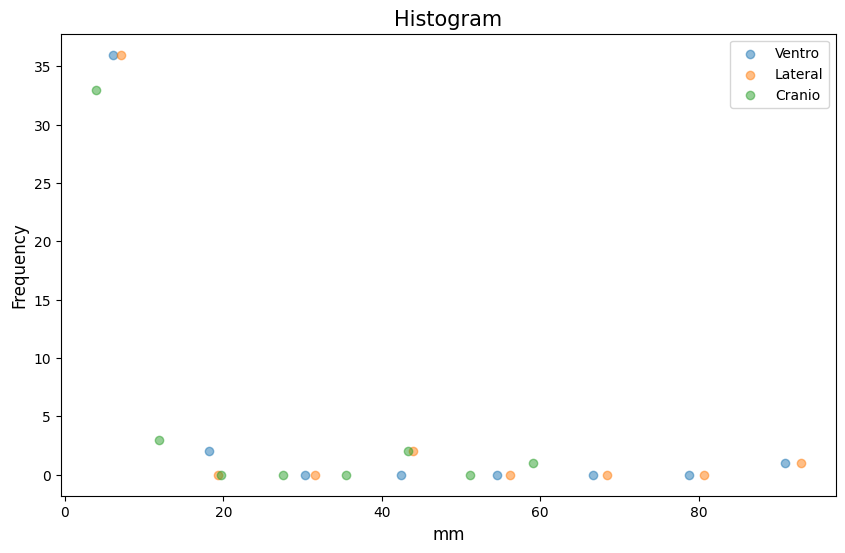

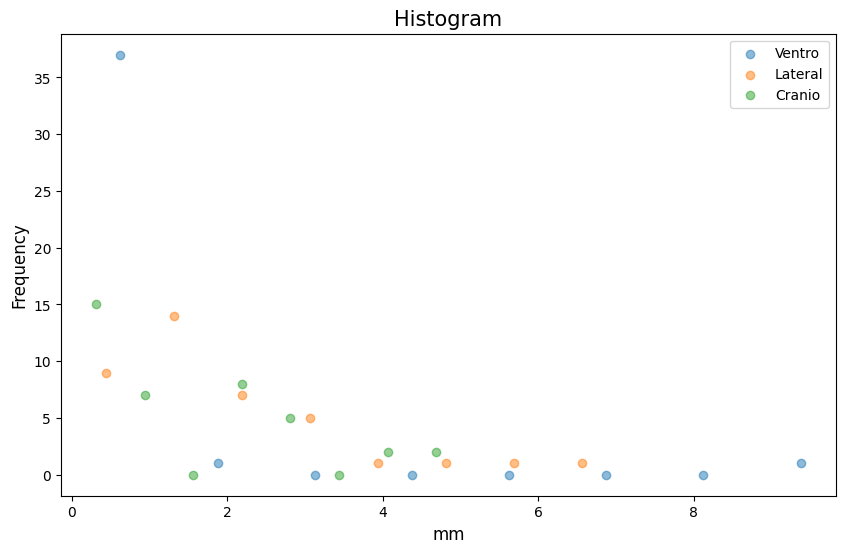

In [122]:
def plot_histogram(datasets, labels, title='Histogram', xlabel='mm', ylabel='Frequency'):  
    np.linspace(min(min(data) for data in datasets), max(max(data) for data in datasets), 15)
    plt.figure(figsize=(10,6))
    bins=8
    for data, label in zip(datasets, labels):
        y, binEdges = np.histogram(data, bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        plt.scatter(bincenters, y, alpha=0.5, label=label)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    #plt.ylim([0, 25])  # Set the limit of y-axis
    plt.legend(loc='upper right')  # Add a legend
    
    plt.show()
    

plot_histogram([hist_ventro_pred,hist_lateral_pred,hist_cranio_pred], ['Ventro', 'Lateral', 'Cranio'])
plot_histogram([hist_ventro_gt,hist_lateral_gt,hist_cranio_gt], ['Ventro', 'Lateral', 'Cranio'])

In [123]:
print("Ventro",np.mean(hist_ventro_pred),np.min(hist_ventro_pred),np.max(hist_ventro_pred),np.median(hist_ventro_pred))
print("Lateral",np.mean(hist_lateral_pred),np.min(hist_lateral_pred),np.max(hist_lateral_pred),np.median(hist_lateral_pred))
print("Cranio",np.mean(hist_cranio_pred),np.min(hist_cranio_pred),np.max(hist_cranio_pred),np.median(hist_cranio_pred))

print("Ventro",np.mean(hist_ventro_true_pred),np.min(hist_ventro_true_pred),np.max(hist_ventro_true_pred),np.median(hist_ventro_true_pred),np.std(hist_ventro_true_pred))
print("Lateral",np.mean(hist_lateral_true_pred),np.min(hist_lateral_true_pred),np.max(hist_lateral_true_pred),np.median(hist_lateral_true_pred),np.std(hist_lateral_true_pred))
print("Cranio",np.mean(hist_cranio_true_pred),np.min(hist_cranio_true_pred),np.max(hist_cranio_true_pred),np.median(hist_cranio_true_pred),np.std(hist_cranio_true_pred))

Ventro 7.487179487179487 0 97 4.0
Lateral 8.717948717948717 1 99 4.0
Cranio 7.589743589743589 0 63 4.0
Ventro 10.051282051282051 0 188 4.0 29.406914168617675
Lateral 4.6923076923076925 0 37 3.0 5.769743566953592
Cranio 7.358974358974359 0 108 3.0 17.493569777590995


In [124]:
print("Ventro", np.mean(hist_ventro_gt), np.min(hist_ventro_gt), np.max(hist_ventro_gt), np.median(hist_ventro_gt))
print("Lateral", np.mean(hist_lateral_gt), np.min(hist_lateral_gt), np.max(hist_lateral_gt), np.median(hist_lateral_gt))
print("Cranio", np.mean(hist_cranio_gt), np.min(hist_cranio_gt), np.max(hist_cranio_gt), np.median(hist_cranio_gt))

print("Ventro", np.mean(hist_ventro_true_gt), np.min(hist_ventro_true_gt), np.max(hist_ventro_true_gt), np.median(hist_ventro_true_gt), np.std(hist_ventro_true_gt))
print("Lateral", np.mean(hist_lateral_true_gt), np.min(hist_lateral_true_gt), np.max(hist_lateral_true_gt), np.median(hist_lateral_true_gt), np.std(hist_lateral_true_gt))
print("Cranio", np.mean(hist_cranio_true_gt), np.min(hist_cranio_true_gt), np.max(hist_cranio_true_gt), np.median(hist_cranio_true_gt), np.std(hist_cranio_true_gt))


Ventro 0.46153846153846156 0 10 0.0
Lateral 1.6666666666666667 0 7 1.0
Cranio 1.435897435897436 0 5 1.0
Ventro 0.6666666666666666 0 18 0.0 2.8495013808837015
Lateral 1.6666666666666667 0 7 1.0 1.6382187533295678
Cranio 1.435897435897436 0 5 1.0 1.4814212128876196


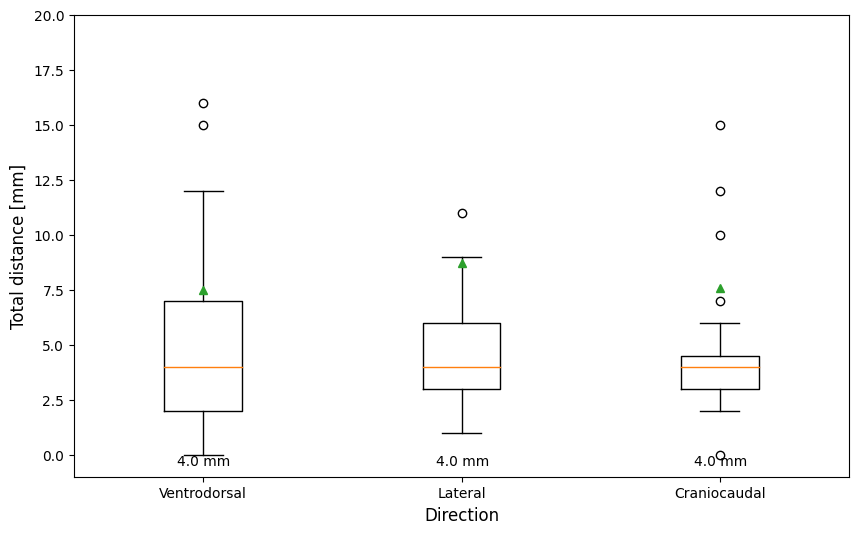

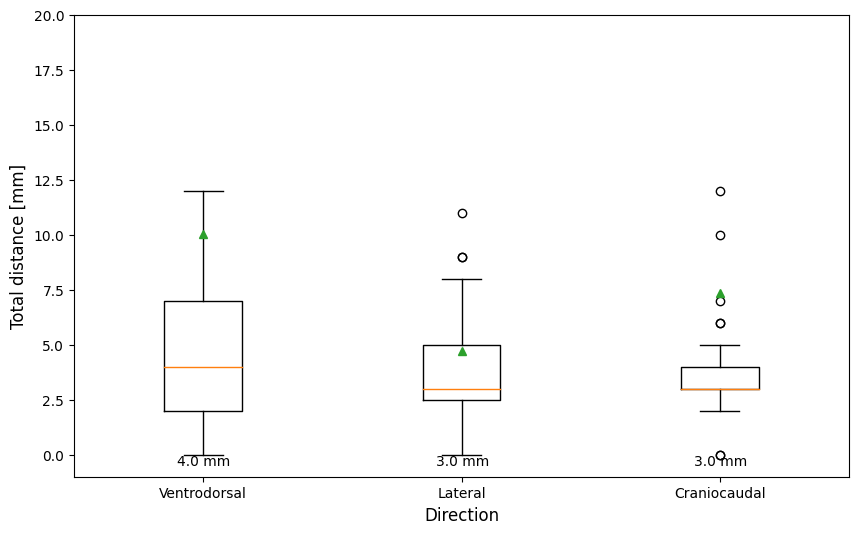

In [127]:
def plot_boxplot(datasets, labels, title=None, xlabel='Direction', ylabel="Total distance [mm]"):
    plt.figure(figsize=(10,6))
    plt.boxplot(datasets, labels=labels,showmeans=True)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.text(0.90,-.30,str(np.round(np.median(datasets[0]),2))+" mm",va="center")
    plt.text(1.90,-.30,str(np.round(np.median(datasets[1]),2))+" mm",va="center")
    plt.text(2.90,-.30,str(np.round(np.median(datasets[2]),2))+" mm",va="center")
    plt.grid(False)
    plt.ylim([-1,20])
    plt.show()
    #plt.savefig('plot_boxplot.tiff', format='tiff', dpi=300)


plot_boxplot([hist_ventro_pred,hist_lateral_pred,hist_cranio_pred], ['Ventrodorsal', 'Lateral', 'Craniocaudal'])
plot_boxplot([hist_ventro_true_pred,hist_lateral_true_pred,hist_cranio_true_pred], ['Ventrodorsal', 'Lateral', 'Craniocaudal'])


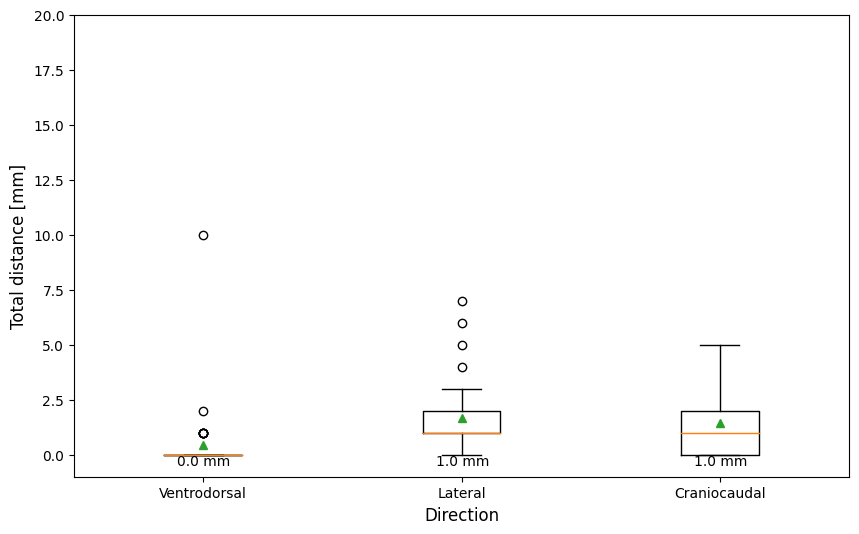

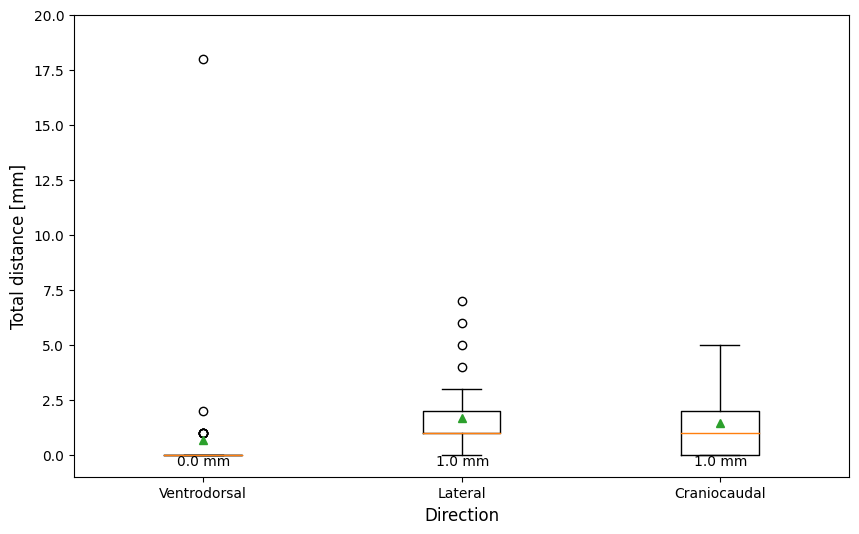

In [128]:
plot_boxplot([hist_ventro_gt, hist_lateral_gt, hist_cranio_gt], ['Ventrodorsal', 'Lateral', 'Craniocaudal'])
plot_boxplot([hist_ventro_true_gt, hist_lateral_true_gt, hist_cranio_true_gt], ['Ventrodorsal', 'Lateral', 'Craniocaudal'])


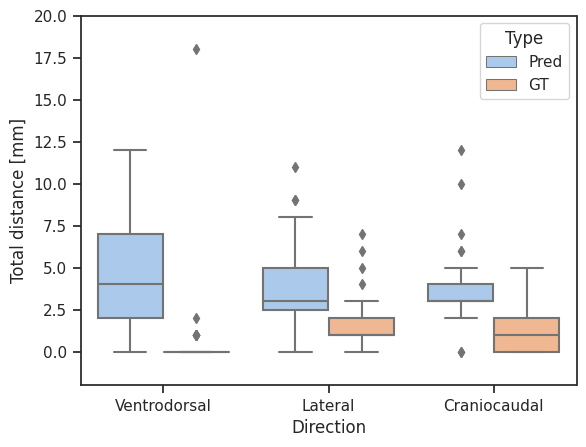

In [149]:

data = [
    (hist_ventro_pred, 'Ventrodorsal', 'Pred'),
    (hist_ventro_gt, 'Ventrodorsal', 'GT'),
    (hist_lateral_pred, 'Lateral', 'Pred'),
    (hist_lateral_gt, 'Lateral', 'GT'),
    (hist_cranio_pred, 'Craniocaudal', 'Pred'),
    (hist_cranio_gt, 'Craniocaudal', 'GT')
]

data_true = [
    (hist_ventro_true_pred, 'Ventrodorsal', 'Pred'),
    (hist_ventro_true_gt, 'Ventrodorsal', 'GT'),
    (hist_lateral_true_pred, 'Lateral', 'Pred'),
    (hist_lateral_true_gt, 'Lateral', 'GT'),
    (hist_cranio_true_pred, 'Craniocaudal', 'Pred'),
    (hist_cranio_true_gt, 'Craniocaudal', 'GT')
]

all_values = []
all_categories = []
all_hues = []

for values, cat, label in data_true:
    all_values.extend(values)
    all_categories.extend([cat] * len(values))
    all_hues.extend([label] * len(values))

df = pd.DataFrame({
    'Direction': all_categories,
    'Total distance [mm]': all_values,
    'Type': all_hues
})

sns.boxplot(x="Direction", y="Total distance [mm]", hue="Type", data=df, palette="pastel")
plt.ylim(-2, 20)
plt.savefig('plot_boxplot_Comparisson.tiff', format='tiff', dpi=300)
plt.show()

